In [1]:
import csv
import numpy as np

data_path = '../data/train.csv'

def load_csv_data(data_path, sub_sample=False):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y == 'b')] = -1

    return yb, input_data, ids

y, x, ids = load_csv_data(data_path)

In [2]:
inds = np.where(x == -999)
x[inds] = np.nan

col_mean = np.nanmedian(x, axis=0)
print(col_mean)

#Find indices that you need to replace
inds = np.where(np.isnan(x))

#Place column means in the indices. Align the arrays using take
x[inds] = np.take(col_mean, inds[1])
print(np.nanmean(x, axis=0))

xmin, xmax = np.min(x, axis=0), np.max(x, axis=0)
x = (x - xmin) / (xmax-xmin)
# xmean, xstd = np.mean(x, axis=0), np.std(x, axis=0)
# x = (x - xmean) / xstd

[ 1.124060e+02  4.652400e+01  7.375200e+01  3.846750e+01  2.107000e+00
  2.258850e+02 -2.440000e-01  2.491500e+00  1.231550e+01  1.206645e+02
  1.280000e+00 -3.560000e-01  4.540000e-01  3.180400e+01 -2.300000e-02
 -3.300000e-02  4.051600e+01 -4.500000e-02  8.600000e-02  3.480200e+01
 -2.400000e-02  1.797390e+02  1.000000e+00  6.556100e+01  0.000000e+00
 -3.300000e-02  4.790200e+01 -1.000000e-02 -2.000000e-03  4.051250e+01]
[ 1.20417434e+02  4.92398193e+01  8.11819816e+01  5.78959617e+01
  2.19310420e+00  2.68220619e+02 -4.11628932e-01  2.37309984e+00
  1.89173324e+01  1.58432217e+02  1.43760943e+00 -1.28304708e-01
  4.55244780e-01  3.87074191e+01 -1.09730480e-02 -8.17107200e-03
  4.66602072e+01 -1.95074680e-02  4.35429640e-02  4.17172345e+01
 -1.01191920e-02  2.09797178e+02  9.79176000e-01  7.71243656e+01
 -1.96589200e-03 -2.06285240e-02  5.07391493e+01 -1.05354440e-02
 -1.87879200e-03  7.30645914e+01]


In [3]:
# replace missing values with mean of col
# col_mean = np.nanmean(x, axis=0)
# inds = np.where(x==-999)
# x[inds] = np.take(col_mean, inds[1])
#
# minmax normalize
# xmin, xmax = np.min(x, axis=0), np.max(x, axis=0)
# x = (x - xmin) / (xmax-xmin)

In [4]:
def compute_mse(y, tx, w):
    e = y-tx.dot(w)
    mse = e.dot(e) / (2 * len(e))
    return mse

def build_poly(x, degree):

    """
    Builds polynomial augmented dataset
    :param x: 
    :param degree: 
    :return:
    """
    r = x.copy()
    for deg in range (2,degree+1):
        r = np.c_[r, np.power(x, deg)]
        
    return np.c_[np.ones(r.shape[0]), r]

def build_k_indices(y, k_fold, seed):
    num_row = y.shape[0]
    interval = int(num_row/k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k*interval: (k+1) * interval] for k in range (k_fold)]
    return np.array(k_indices)

def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):

    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """

    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]
            
def ridge_regression(y, tx, lambda_):
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    return np.linalg.solve(a,b)

In [65]:
# try training with different lambdas and refine the lambdas depending on what magnitude turns out to be best
# same idea with degrees
import pickle

lambdas = np.array([1e-20]) #np.logspace(-25,2,10)
degrees = np.arange(1,10)
seed = 12
k_fold = 7


def predict(tx, w):
    return tx.dot(w)

def cross_validation(y, x, k_indices, k, lambda_, degree):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te, y_tr = y[te_indice], y[tr_indice]
    x_te, x_tr = x[te_indice], x[tr_indice]
    
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    
    w = ridge_regression(y_tr, tx_tr, lambda_)
    
    loss_tr = compute_mse(y_tr, tx_tr, w)
    loss_te = compute_mse(y_te, tx_te, w)
    
    y_tr_pred = predict(tx_tr, w)
    y_te_pred = predict(tx_te, w)
    print(np.min(y_te_pred),np.max(y_te_pred))
    
    y_tr_pred[np.where(y_tr_pred <= 0)] = -1
    y_tr_pred[np.where(y_tr_pred > 0)] = 1
    
    y_te_pred[np.where(y_te_pred <= 0)] = -1
    y_te_pred[np.where(y_te_pred > 0)] = 1

    loss_tr_acc = sum(y_tr_pred != y_tr)/len(y_tr)
    loss_te_acc = sum(y_te_pred != y_te)/len(y_te)
    
    return loss_tr, loss_te, w, loss_tr_acc, loss_te_acc

def cross_validation_demo():
   
    k_indices = build_k_indices(y, k_fold, seed)

    best_lambdas = []
    best_losses = []
    best_weights = []
    best_losses_tr = []
    best_losses_te_acc = []
    best_losses_tr_acc = []
    
    j = 0 #jth degree
    for deg in degrees:
        i = 0 #ith lambda
        losses_te = []
        losses_tr = []
        losses_te_acc = []
        losses_tr_acc = []
        ws = []
        for lambda_ in lambdas:
            print(f'Lambda {lambdas[i]}, degree {degrees[j]}')
            i += 1
            ws_tmp = []
            loss_te_tmp = []
            loss_tr_tmp = []
            loss_te_acc_tmp = []
            loss_tr_acc_tmp = []
            
            for k in range(k_fold):
                #print(f'Fold {k}/{k_fold}')
                loss_tr, loss_te, w, loss_tr_acc, loss_te_acc = cross_validation(y, x, k_indices, k, lambda_, deg)
                
                loss_te_tmp.append(loss_te)
                loss_tr_tmp.append(loss_tr)
                loss_te_acc_tmp.append(loss_te_acc)
                loss_tr_acc_tmp.append(loss_tr_acc)
                ws_tmp.append(w)
            losses_te.append(np.mean(loss_te_tmp, axis=0))
            losses_tr.append(np.mean(loss_tr_tmp, axis=0))
            losses_te_acc.append(np.mean(loss_te_acc_tmp, axis=0))
            losses_tr_acc.append(np.mean(loss_tr_acc_tmp, axis=0))
            ws.append(np.mean(ws_tmp, axis=0))
            
            def predict(tx, w):
                return tx.dot(w)

            y_pred = predict(build_poly(x, deg), np.mean(ws_tmp, axis=0))
            y_pred[np.where(y_pred <= 0)] = -1
            y_pred[np.where(y_pred > 0)] = 1
        
            print(f'Total predicted {sum(y_pred == y)}, Test {np.mean(loss_te_acc_tmp, axis=0)} Training misclassification {np.mean(loss_tr_acc_tmp, axis=0)}') # how many would the trained model predict on the train set

        j += 1
        ind_lambda_opt = np.argmin(loss_te)
        best_lambdas.append(lambdas[ind_lambda_opt])
        best_losses.append(losses_te[ind_lambda_opt])
        best_weights.append(ws[ind_lambda_opt])
        best_losses_tr.append(losses_tr[ind_lambda_opt])
        best_losses_te_acc.append(losses_te_acc[ind_lambda_opt])
        best_losses_tr_acc.append(losses_tr_acc[ind_lambda_opt])
        
        with open('../../vars_ridge.pkl', 'wb') as f:
            pickle.dump([best_lambdas,best_losses,best_losses_tr,best_weights, best_losses_te_acc, best_losses_tr_acc], f)
        
    ind_best_degree = np.argmin(best_losses)

    return degrees[ind_best_degree], best_lambdas, best_weights, best_losses, best_losses_tr, best_losses_te_acc, best_losses_tr_acc

best_degree, best_lambdas_per_degree, best_weights_per_degree, best_losses_te, best_losses_tr, best_losses_te_acc, best_losses_tr_acc = cross_validation_demo()

Lambda 1e-20, degree 1
-3.6948663678483626 2.8124660845073777
-3.7049491309156224 2.8494775597653756
-3.4208944212335837 4.752404292059737
-3.795397740338558 3.5859796752183932
-4.545590640663875 2.9055538129203597
-4.45425273269916 3.2114288384565555
-3.0169640826607065 2.91178573796509
Total predicted 186247, Test 0.2549900399203193 Training misclassification 0.2549347061443158
Lambda 1e-20, degree 2
-3.588426153193268 3.326276018334795
-3.6920449491054796 1.8540675080589182
-16.367062355184657 5.037129494512669
-7.691833723273366 2.854596963254153
-3.639362235117378 174.49996452865722
-4.505748112687712 4.370549754032822
-3.8594905599518228 3.225008060028358
Total predicted 193700, Test 0.22540180321442574 Training misclassification 0.22520113494241287
Lambda 1e-20, degree 3
-3.3158881360572536 2.001320764498473
-3.2307459037232196 5.254826236719282
-5.004502321125983 27.6115827051799
-3.522459935759798 10.887612300645628
-1902.3005959867046 2.5146088787278416
-3.0812906924459753 8.

In [18]:
best_degree

1

In [17]:
best_lambdas_per_degree

[1e-25, 1e-25, 1e-25, 1e-25, 1e-25, 1e-25]

In [ ]:
# is there any way to show that the lambda preferred by both lowest mse and lowest misclassifications is the same?

In [6]:
best_losses_te

[10615.262765634072, 53254223.52679757]

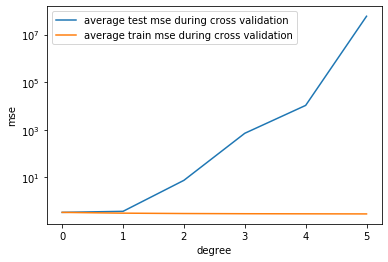

In [27]:
import matplotlib.pyplot as plt

plt.plot(best_losses_te, label='average test mse during cross validation')
plt.plot(best_losses_tr, label='average train mse during cross validation')
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('mse')
plt.legend(loc="upper left")
plt.show()

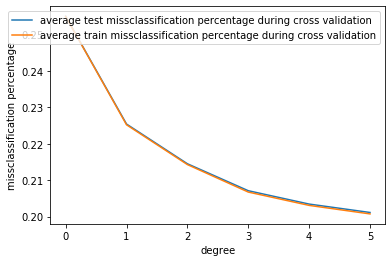

In [30]:
import matplotlib.pyplot as plt

plt.plot(best_losses_te_acc, label='average test missclassification percentage during cross validation')
plt.plot(best_losses_tr_acc, label='average train missclassification percentage during cross validation')
plt.xlabel('degree')
plt.ylabel('missclassification percentage')
plt.legend(loc="upper right")
plt.show()

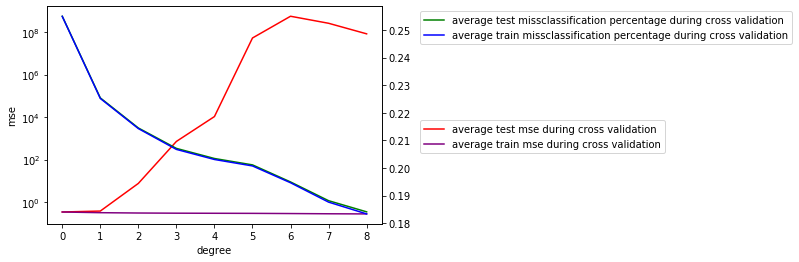

In [82]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()


ax.plot(best_losses_te, color='red', label='average test mse during cross validation')
ax.plot(best_losses_tr, color='purple', label='average train mse during cross validation')
ax.set_yscale('log')
ax.set_xlabel('degree')
ax.set_ylabel('mse')
ax.legend(bbox_to_anchor=(1.1, 0.5))
ax2=ax.twinx()

ax2.plot(best_losses_te_acc, color='green', label='average test missclassification percentage during cross validation')
ax2.plot(best_losses_tr_acc, color='blue', label='average train missclassification percentage during cross validation')
ax2.legend(bbox_to_anchor=(1.1, 1))


In [7]:
def predict(tx, w):
    return tx.dot(w)

y_pred = predict(build_poly(x, best_degree), best_weights_per_degree[0])
y_pred[np.where(y_pred <= 0)] = -1
y_pred[np.where(y_pred > 0)] = 1

sum(y_pred == y)

199242

Text(0, 0.5, 'Y prediction')

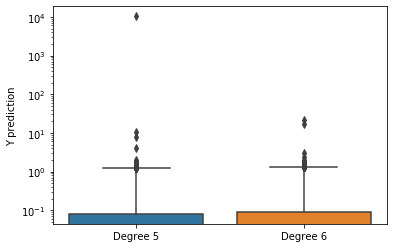

In [83]:
import seaborn as sns

y_pred_deg_5 = predict(build_poly(x, 5), best_weights_per_degree[4])
y_pred_deg_6 = predict(build_poly(x, 6), best_weights_per_degree[5])

ax = sns.boxplot(data=[y_pred_deg_5,y_pred_deg_6])
ax.set_yscale('log')
ax.set_xticklabels(['Degree 5','Degree 6'])
ax.set_ylabel('Y prediction')

In [109]:
test_path = '../data/test.csv'

y, x, ids = load_csv_data(test_path)

In [110]:
# replace missing values with mean of col
inds = np.where(x==-999)
x[inds] = np.take(col_mean, inds[1])

# minmax normalize
x = (x - xmin) / (xmax-xmin)

In [113]:
def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in csv format for submission to kaggle
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})

            
y_pred = predict(build_poly(x, 9), best_weights_per_degree[0])
y_pred[np.where(y_pred <= 0)] = -1
y_pred[np.where(y_pred > 0)] = 1

#create_csv_submission(ids, y_pred, 'ridge_deg9_1e-18.csv')